In [1]:
import pathlib
import subprocess
import h5py
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Clean up any old files
import shutil
shutil.rmtree('analysis', ignore_errors=True)

In [4]:
# Build bases and domain
x_basis = de.Chebyshev('x', 1024, interval=(0, 300), dealias=2)
domain = de.Domain([x_basis], grid_dtype=np.complex128)

# Build problem
problem = de.IVP(domain, variables=['u', 'ux'])
problem.parameters['b'] = 0.5
problem.parameters['c'] = -1.76
problem.substitutions["mag_sq(A)"] = "A * conj(A)"
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(ux) = - (1 + 1j*c) * mag_sq(u) * u")
problem.add_equation("ux - dx(u) = 0")
problem.add_equation("left(u) = 0")
problem.add_equation("right(u) = 0")

# Build solver
solver = problem.build_solver('RK222')
solver.stop_sim_time = 500
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']

# Setup a sine wave
u.set_scales(1)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)
u.differentiate('x', out=ux);

2021-08-05 23:01:13,167 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s


In [5]:
analysis = solver.evaluator.add_file_handler('analysis', iter=10, max_writes=200)

In [6]:
analysis.add_task("integ(sqrt(mag_sq(u)),'x')/300", layout='g', name='<|u|>')

In [7]:
analysis.add_system(solver.state, layout='g')

In [8]:
# Main loop
dt = 0.05
while solver.ok:
    solver.step(dt)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2021-08-05 23:10:14,904 solvers 0/1 INFO :: Simulation stop time reached.


In [9]:
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis_s5
analysis/analysis_s5/analysis_s5_p0.h5
analysis/analysis_s3
analysis/analysis_s3/analysis_s3_p0.h5
analysis/analysis_s4
analysis/analysis_s4/analysis_s4_p0.h5
analysis/analysis_s2
analysis/analysis_s2/analysis_s2_p0.h5
analysis/analysis_s1
analysis/analysis_s1/analysis_s1_p0.h5



In [10]:
from dedalus.tools import post
post.merge_process_files("analysis", cleanup=True)

2021-08-05 23:17:23,127 post 0/1 INFO :: Merging files from analysis


In [11]:
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis_s2.h5
analysis/analysis_s5.h5
analysis/analysis_s1.h5
analysis/analysis_s3.h5
analysis/analysis_s4.h5



In [12]:
set_paths = list(pathlib.Path("analysis").glob("analysis_s*.h5"))
post.merge_sets("analysis/analysis.h5", set_paths, cleanup=True)

2021-08-05 23:18:46,155 post 0/1 INFO :: Creating joint file analysis/analysis.h5


In [13]:
print(subprocess.check_output("find analysis", shell=True).decode())

analysis
analysis/analysis.h5



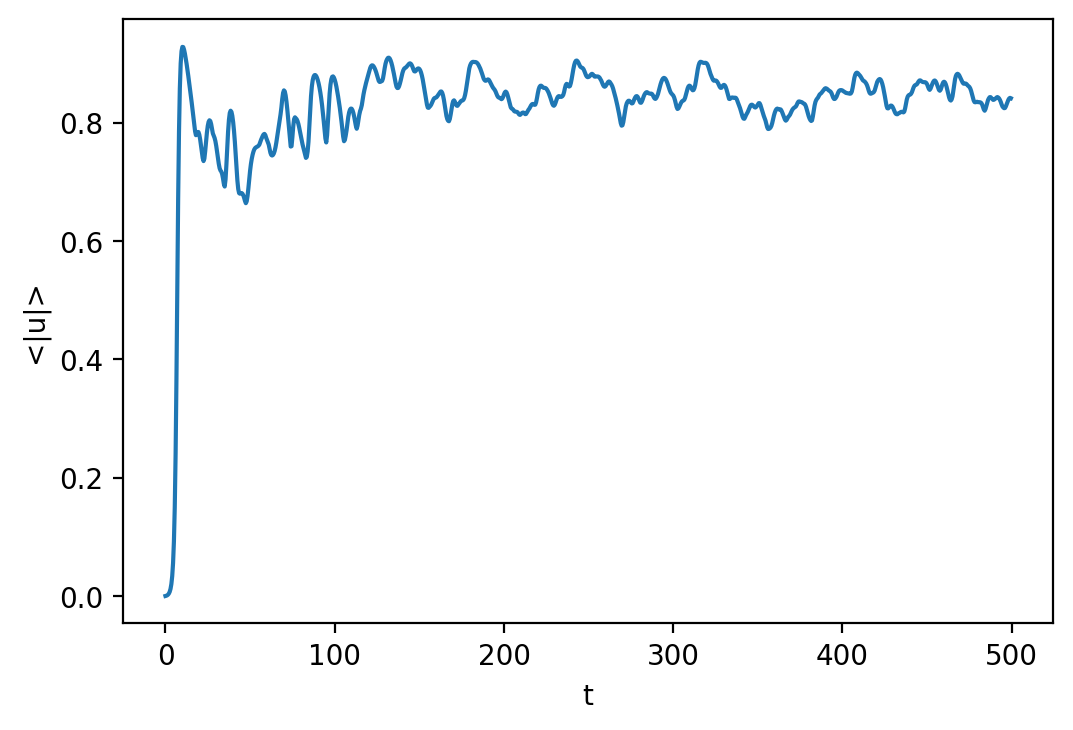

In [14]:
with h5py.File("analysis/analysis.h5", mode='r') as file:
    # Load datasets
    mag_u = file['tasks']['<|u|>']
    t = mag_u.dims[0]['sim_time']
    # Plot data
    fig = plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(t[:], mag_u[:].real)
    plt.xlabel('t')
    plt.ylabel('<|u|>')

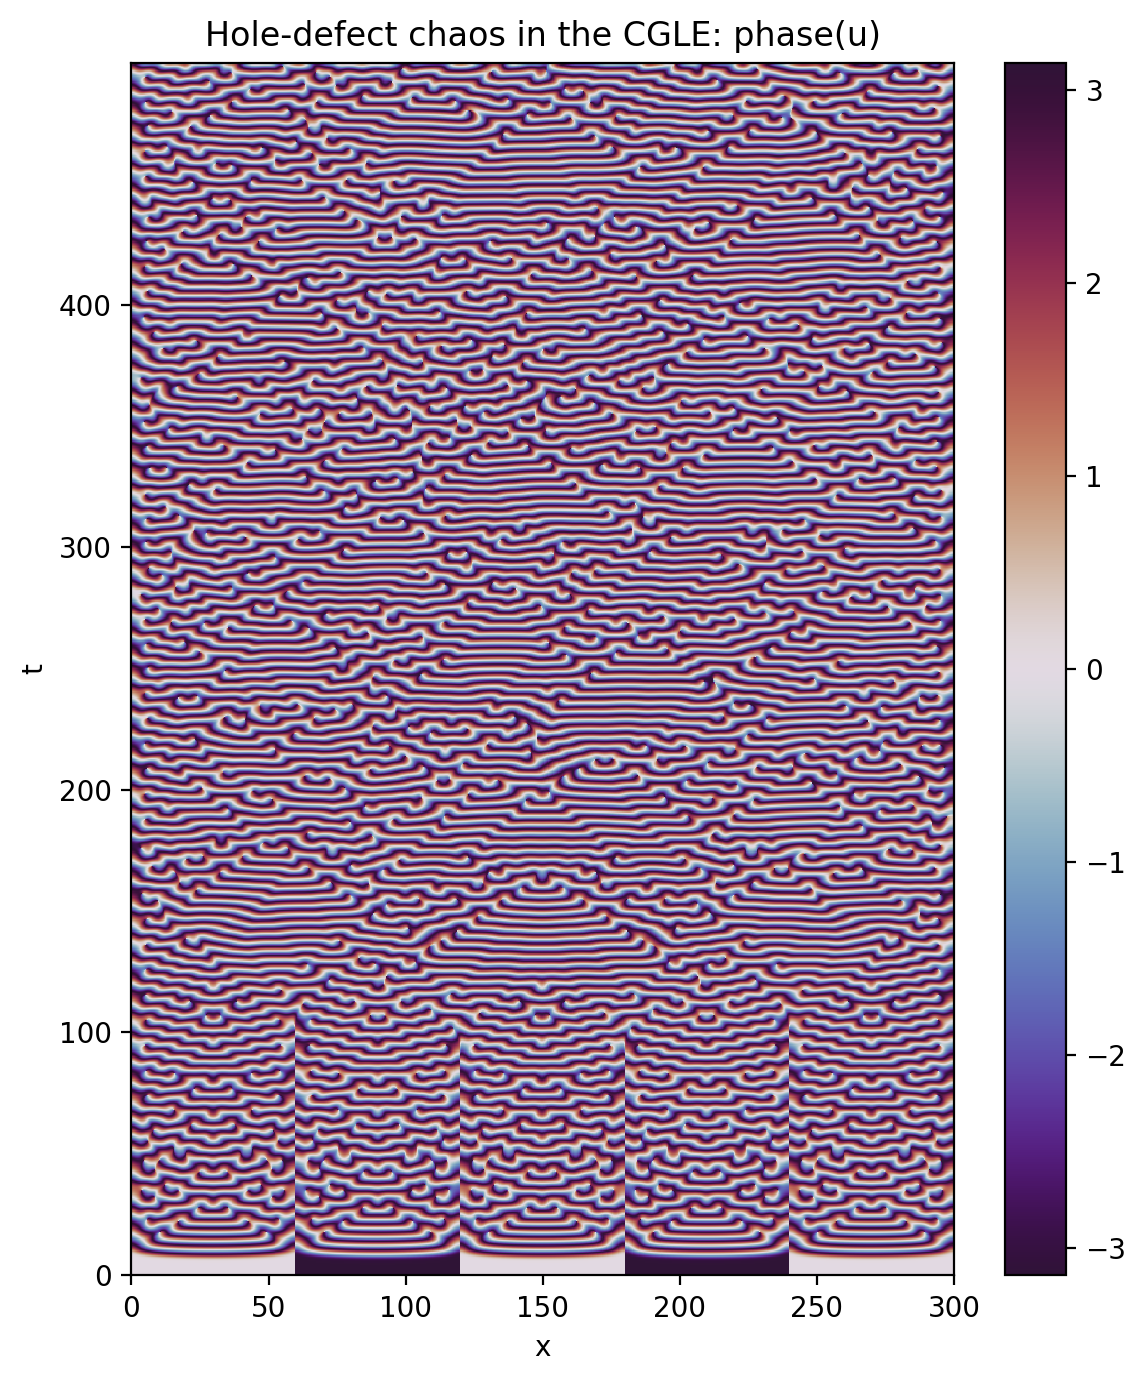

In [15]:
with h5py.File("analysis/analysis.h5", mode='r') as file:
    # Load datasets
    u = file['tasks']['u']
    t = u.dims[0]['sim_time']
    x = u.dims[1][0]
    # Plot data
    u_phase = np.arctan2(u[:].imag, u[:].real)
    plt.figure(figsize=(6,7), dpi=100)
    plt.pcolormesh(x[:], t[:], u_phase, shading='nearest', cmap='twilight_shifted')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Hole-defect chaos in the CGLE: phase(u)')
    plt.tight_layout()